Section 0

In [0]:
#@title Default title text
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
from os import listdir
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab import drive
import random
from skimage import data
from skimage.transform import pyramid_gaussian

drive.mount('/content/gdrive')
gdrive = "/content/gdrive/My Drive/ProjectHumanDetection/"

pos_test_path = 'INRIAPerson/70X134H96/Test/pos/'
neg_test_path = 'INRIAPerson/Test/neg'
pos_train_path = 'INRIAPerson/96X160H96/Train/pos/'
neg_train_path = 'INRIAPerson/Train/neg'



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Section 1

In [0]:
# Process the images for testing and traning
def generate_pos_images(directory, padding):
  """ for each image in the pos (str)directory, remove the (int)paddings on each
  side and generate a pos image of size 64X128.
  return a ndarray of all the pos images
  
  note: manipulate limit for smaller testing
  """
  files = listdir(directory)
  limit = len(files)
  results = np.zeros((limit, 128, 64))
  fill = 0
  for png in files[:limit]:
    img = cv2.cvtColor(cv2.imread(directory +'/' + png), cv2.COLOR_RGB2GRAY)
    results[fill, :, :] = img[padding:padding+128, padding:padding+64]
    fill += 1
    if fill % 100 == 0: # progress check
      print(fill, 'pos')
  return results


def generate_neg_images(directory, n):
  """ for each image in the neg (str)directory, generate (int)n random windows \
  of neg images of size 64X128.
  return a ndarray of all the neg images
  
  note: manipulate limit for smaller testing
  """
  files = listdir(directory)
  limit = len(files)
  results = np.zeros((limit * n, 128, 64))
  links = []
  fill = 0
  for png in files[:limit]:
    img = cv2.cvtColor(cv2.imread(directory +'/' + png), cv2.COLOR_RGB2GRAY)
    y, x = img.shape
    for i in range(n):
      if y > 128 and x > 64:
        randy = random.randint(0, y - 128)
        randx = random.randint(0, x - 64)
        results[fill, :, :] = img[randy:randy+128, randx:randx+64]
        links.append(png)
      fill += 1
      if fill % 100 == 0: # progress check
        print(fill, 'neg')
  return results, links

Section 2

In [0]:
train_pos = generate_pos_images(gdrive + pos_train_path, 16)
train_pos_label = np.ones((train_pos.shape[0]))
train_neg, train_links = generate_neg_images(gdrive + neg_train_path, 10)
train_neg_label = np.zeros((train_neg.shape[0]))
test_pos = generate_pos_images(gdrive + pos_test_path, 3)
test_pos_label = np.ones((test_pos.shape[0]))
test_neg, test_links = generate_neg_images(gdrive + neg_test_path, 10)
test_neg_label = np.zeros((test_neg.shape[0]))

train_images = np.concatenate((train_pos, train_neg), axis=0)
train_labels = np.concatenate((train_pos_label, train_neg_label), axis=0)

test_images = np.concatenate((test_pos, test_neg), axis=0)
test_labels = np.concatenate((test_pos_label, test_neg_label), axis=0)


Section 3

In [0]:
def get_hog_descriptors(images):
  """ gets the hog descriptors for each of the images, and returns a
  ndarray containing all the descriptors
  """
  img_count = images.shape[0]
  hog = cv2.HOGDescriptor()
  results = np.zeros((img_count, 3780, 1))
  for i in range(img_count):
    results[i, :, :] = hog.compute(images[i, :, :].astype(np.uint8))
  return results

train_hog = get_hog_descriptors(train_images) 
test_hog = get_hog_descriptors(test_images)


Section 4

Train on 14616 samples, validate on 5656 samples
Epoch 1/6
14616/14616 [==============================] - 1s 54us/step - loss: 0.2583 - acc: 0.8926 - val_loss: 0.1233 - val_acc: 0.9613
Epoch 2/6
14616/14616 [==============================] - 1s 38us/step - loss: 0.0884 - acc: 0.9719 - val_loss: 0.0672 - val_acc: 0.9800
Epoch 3/6
14616/14616 [==============================] - 1s 37us/step - loss: 0.0568 - acc: 0.9819 - val_loss: 0.0515 - val_acc: 0.9848
Epoch 4/6
14616/14616 [==============================] - 1s 37us/step - loss: 0.0451 - acc: 0.9856 - val_loss: 0.0460 - val_acc: 0.9860
Epoch 5/6
14616/14616 [==============================] - 1s 38us/step - loss: 0.0360 - acc: 0.9885 - val_loss: 0.0428 - val_acc: 0.9867
Epoch 6/6
14616/14616 [==============================] - 1s 39us/step - loss: 0.0326 - acc: 0.9896 - val_loss: 0.0415 - val_acc: 0.9869
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


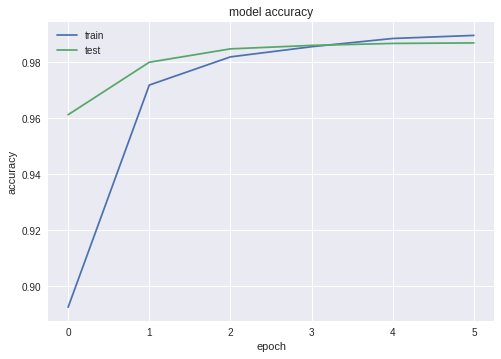

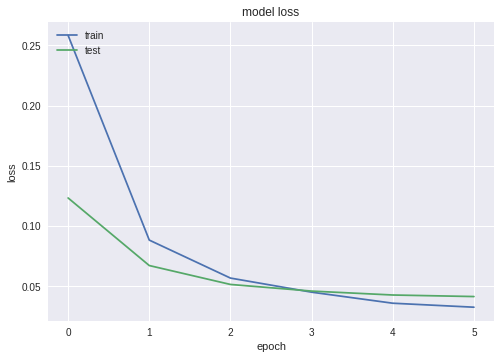

In [0]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(3780, 1)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(2, activation=tf.nn.softmax)
])

model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_hog, train_labels,
                    validation_data=(test_hog, test_labels)
                    , batch_size=256, epochs=6)

# plot code sourced from: https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Section 5

In [0]:
# find false positives in training samples
prediction = model.predict(get_hog_descriptors(train_neg))
hard_neg_images = []
# if model predicts more than (thres)% chance person exits, investigate neg
# and try to pull more hard examples from the image
thres = 0.40
for i in range(prediction.shape[0]):
  if prediction[i, 1] > thres:
    if train_links[i] not in hard_neg_images:
      hard_neg_images.append(train_links[i])

print(len(hard_neg_images))
extra_samples = []
# investigate hard image
for imgs in hard_neg_images:
  image = cv2.cvtColor(cv2.imread(gdrive + neg_train_path +'/' + imgs),\
                       cv2.COLOR_RGB2GRAY)
  pyrimid =tuple(pyramid_gaussian(image, max_layer=5, downscale=1.3))
  for pic in pyrimid:
    y_max, x_max = pic.shape
    y = 0
    # sliding box to find hard examples
    while y < y_max - 128:
      x = 0
      while x < x_max - 64:
        sample = pic[y:y+128, x:x+64]
        hog_des = get_hog_descriptors(np.array([sample * 255]))
        if model.predict(hog_des)[0, 1] > thres:
          extra_samples.append(hog_des)
        # shift 16 pixels 
        x += 16
      y += 16
print(len(extra_samples))
  
# put the added extra examples in a array
extra_neg_hog = np.zeros((len(extra_samples), 3780, 1))
for i in range(len(extra_samples)):
  extra_neg_hog[i, :, :] = extra_samples[i]
  
  

91


Section 6

In [0]:
  
  
# retrain a new model with the added hard examples
extra_train_hog = np.concatenate((train_hog, extra_neg_hog), axis=0)
extra_neg_labels = np.zeros((extra_neg_hog.shape[0]))
extra_train_labels = np.concatenate((train_labels, extra_neg_labels), axis=0)


final_model = keras.Sequential([
  keras.layers.Flatten(input_shape=(3780, 1)),
  keras.layers.Dense(128, activation=tf.nn.relu),
  keras.layers.Dense(2, activation=tf.nn.softmax)
])
  

final_model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = final_model.fit(extra_train_hog, extra_train_labels,
                    validation_data=(test_hog, test_labels)
                    , batch_size=256, epochs=10)

# plot code sourced from: 
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()  

Section 7

In [0]:
# save the final model !
final_model.save(gdrive + 'humanDectectionModel')

In [0]:
# test loaded model
c = keras.models.load_model(gdrive + 'humanDectectionModel')

a = cv2.imread(gdrive + pos_test_path + 'crop_000001a.png')
a = cv2.cvtColor(a, cv2.COLOR_RGB2GRAY)
d = np.array([a])
hog = get_hog_descriptors(d)

print(c.predict(hog))